In [2]:
from tqdm import tqdm
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.graphs import KG, Vertex
from pyrdf2vec.embedders import FastText,Word2Vec
from pyrdf2vec.walkers import RandomWalker
from pyvis.network import Network
from sklearn.manifold import TSNE
from umap import UMAP
from SPARQLWrapper import SPARQLWrapper
from jcopml.plot import plot_missing_value

import plotly.express as px
import pandas as pd
import numpy as np
import requests
import os
import networkx as nx
import matplotlib.pyplot as plt

from modul.vectorReferenced import get_taxon_vector,cek_ncbi_id_by_wiki_id_via_string
from modul.filterNodeEdge import removeNodeAndEdgeByFilter,removeEdgesNotInNodes
from modul.helper_umum import contains_string_entire_column,contains_string_entire_column_boolean, minmax, std_scale
#from process import cek_bfs, nx_to_pyviz
from modul.grafHelper import _set_networkx_graph, _plot_nx_by_matplotlib
from modul.visualisasiHelper import embeddingPlot,plotly_graph
from modul.embeddingHelper import df_serangga_to_rdf, rdf_KG_to_embeddings, df_to_dictionary_taxon
from modul.custom_degree_centrality import degree_centrality_custom

/Users/mohzulkiflikatili/miniconda3/envs/thesis-flask/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/mohzulkiflikatili/miniconda3/envs/thesis-flask/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/mohzulkiflikatili/miniconda

In [3]:
data=[
    ('begomovirus_contoh_hasil','Pepper yellow leaf curl virus','Aleyrodidae','Bemisia Tabaci'),
    ('1cucu','Cucumber mosaic virus','Aphididae','Myzus persicae'),
    ('2cri','Tomato chlorosis virus','Aleyrodidae','Bemisia Tabaci'),
    ('3wai','Maize chlorotic dwarf virus','Cicadellidae','Graminella nigrifrons'),
    ('4beg','Tomato yellow leaf curl China virus','Aleyrodidae','Bemisia Tabaci'),
    ('5pol','Cereal yellow dwarf virus','Aphididae','Schizaphis graminum'),
    ('6pea','Pea enation mosaic virus 1','Aphididae','Acyrthosiphon pisum'),
    ('7cucur','Cucurbit yellow stunting disorder virus','Aleyrodidae','Bemisia Tabaci'),
    ('8ten','Rice stripe tenuivirus','Delphacidae','Laodelphax striatellus'),
    ('9fiji','Southern rice black-streaked dwarf virus','Delphacidae','Sogatella furcifera'),
    ('10capchlo','Capsicum chlorosis orthotospovirus','Thripidae','Thrips Palmi'),
    ('11barley','Barley yellow dwarf virus GAV','Aphididae','Sitobion avenae'),
    ('12tospot','Tomato spotted wilt orthotospovirus','Thripidae','Frankliniella occidentalis'),
    ('13svyv','squash vein yellowing virus','Aleyrodidae','Bemisia Tabaci'),
    ('14sbmv','soybean mosaic virus','Aphididae','Aphis glycines'),
    ('15blv','bean leafroll virus','Aphididae','Acyrthosiphon pisum'),
    ('16rgdv','rice gall dwarf virus','Cicadellidae','Recilia dorsalis'), #sedikit
    ('17srbsdv','southern rice black-streaked dwarf virus','Delphacidae','Sogatella furcifera'),
    ('18tsrv','tomato severe rugose virus','Aleyrodidae','Bemisia tabaci'),
    ('19gbnv','groundnut bud necrosis virus','Thripidae','Thrips palmi'),
    ('20wbnv','Watermelon bud necrosis virus','Thripidae','Thrips palmi'),
    # error dibawah ini
    # ('+13Poty','Potyvirus','Aphididae','Myzus'),
    # ('+11tung','Tungrovirus','Nilaparvata','Nilaparvata'),
]

data_,nama_virus,acuan_,ujian_=data[0] # vektor acuan  #data virus
# link enpoint sparql ncbi_ontology
ncbi_ontology_url = 'http://localhost:3030/mydataset/query'

In [4]:
#1
#baca data
df_node=pd.read_csv('dari_praproses/'+data_+'_node.csv',index_col=0) 
df_edge=pd.read_csv('dari_praproses/'+data_+'_edge.csv',index_col=0)

In [5]:
# cuma tampilan
import plotly.graph_objects as go

data = df_node.groupby(['group','color']).agg({'group': ['count'], }).reset_index().sort_values(
    ('group', 'count'),ascending=False
).reset_index(drop=True).values
labels = [i[0] for i in data]
colors = [i[1] for i in data]
slices = [i[2] for i in data]

fig = go.Figure(data=[go.Pie(labels=labels,values=slices)])
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=20, marker=dict(colors=colors, line=dict(color='#000000', width=0.1)))
fig.show()

In [6]:
# edge
grup_edge=df_edge.groupby('interaction_type').size().to_dict()
grup_edge.keys()
labels = list(grup_edge.keys())
colors = ['#ec583e', '#04cb94', '#636cfb', '#ab63fa', '#ffa15a']  # Ganti dengan warna yang Anda inginkan
slices = list(grup_edge.values())

fig = go.Figure(data=[go.Pie(labels=labels,values=slices)])
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=20, marker=dict(line=dict(color='#000000', width=0.1)))
fig.show()

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Data untuk plot pertama
data_node = df_node.groupby(['group','color']).agg({'group': ['count'], }).reset_index().sort_values(
    ('group', 'count'),ascending=False
).reset_index(drop=True).values
labels_node = [i[0] for i in data_node]
colors_node = [i[1] for i in data_node]
slices_node = [i[2] for i in data_node]

# Data untuk plot kedua
grup_edge=df_edge.groupby('interaction_type').size().to_dict()
labels_edge = list(grup_edge.keys())
slices_edge = list(grup_edge.values())

# Buat subplot dengan dua plot di dalamnya
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'pie'}, {'type':'pie'}]])

# Plot pertama (Node)
fig.add_trace(
    go.Pie(labels=labels_node, values=slices_node, marker=dict(colors=colors_node, line=dict(color='#000000', width=0.1))),
    row=1, col=1
)
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=20)

# Plot kedua (Edge)
fig.add_trace(
    go.Pie(labels=labels_edge, values=slices_edge, marker=dict(line=dict(color='#000000', width=0.1))),
    row=1, col=2
)
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=20)

# Tampilkan plot
fig.show()


In [8]:
import plotly.graph_objects as go

# Data dari grup_edge
labels = list(grup_edge.keys())
values = list(grup_edge.values())

# Hitung total data
total_data = sum(values)

# Hitung persentase masing-masing kategori
percentages = [(value / total_data) * 100 for value in values]

# Membuat diagram batang dengan warna yang bervariasi dan nilai jumlah
colors = ['#ec583e', '#04cb94', '#636cfb', '#ab63fa', '#ffa15a']  # Ganti dengan warna yang Anda inginkan
fig = go.Figure(data=[go.Bar(x=labels, y=values, marker_color=colors)])


# Menambahkan nilai jumlah pada tiap batang
for i, (value, percentage) in enumerate(zip(values, percentages)):
    fig.add_annotation(
        x=labels[i],
        y=value + 100,
        text=f"{value} ({percentage:.2f}%)",
        showarrow=False,
        font=dict(size=12, color='black'),  # Warna teks putih
        textangle=0,
    )

# Menambahkan label pada sumbu x dan y
fig.update_xaxes(title_text='Interaction Type')
fig.update_yaxes(title_text='Count')

# Menambahkan judul diagram
fig.update_layout(title_text='Diagram Batang Interaksi dengan Warna yang Bervariasi dan Nilai Jumlah')

# Menampilkan diagram
fig.show()


In [9]:
import networkx as nx
import matplotlib.pyplot as plt

#3
#konversi graph 
gnx = nx.MultiDiGraph()
#node
for i,a in df_node.iterrows():
    #mulai disini akan digunakan taksonomi bahasa indonesia pada data.
    gnx.add_node(
        a['taxon_id'],
        label=a['taxon_name'],
        superkingdom=a['superkingdom'],
        kingdom=a['kingdom'],
        filum=a['phylum'],
        kelas=a['class'],
        ordo=a['order'],
        famili=a['family'],
        genus=a['genus'],
        spesies=a['species'],
        group=a['group'],
        color=a['color'],
    )
#edge
for i,a in df_edge.iterrows():
    gnx.add_edge(
        a['source_taxon_id'],
        a['target_taxon_id'],
        label=a['interaction_type'],
    )

In [10]:
import plotly.graph_objects as go
G=gnx
pos = nx.nx_agraph.graphviz_layout(G, prog="neato", args="")
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line= {"width":0.5, "color":'#888'},
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
node_colors = []
node_text = []
for node,data in G.nodes(data=True):
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_colors.append(data['color'])
    node_text.append(data['label'])

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker={
        # 'showscale':True,
        # 'colorscale':'Reds',
        'reversescale':True,
        'color':[],
        'size':10,
        # 'colorbar':{
        #     # 'thickness':15,
        #     # 'title':'Node Connections',
        #     # 'xanchor':'left',
        #     # 'titleside':'right'
        # },
        'line_width':2   
    }
)
node_trace.marker.color = node_colors
node_trace.text = node_text

In [11]:
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title='Network graph made with Python',
        titlefont_size=16,
        showlegend=False,
        hovermode='closest',
        margin={
            'b':20,'l':5,'r':5,'t':40
        },
        annotations=[{
            "text":"Insect-virus-plant",
            'showarrow':False,
            'xref':"paper", 
            'yref':"paper",
            'x':0.005, 
            'y':-0.002 
        }],
        xaxis={'showgrid':False, 'zeroline':False, 'showticklabels':False},
        yaxis={'showgrid':False, 'zeroline':False, 'showticklabels':False}
    )
)
fig.show()

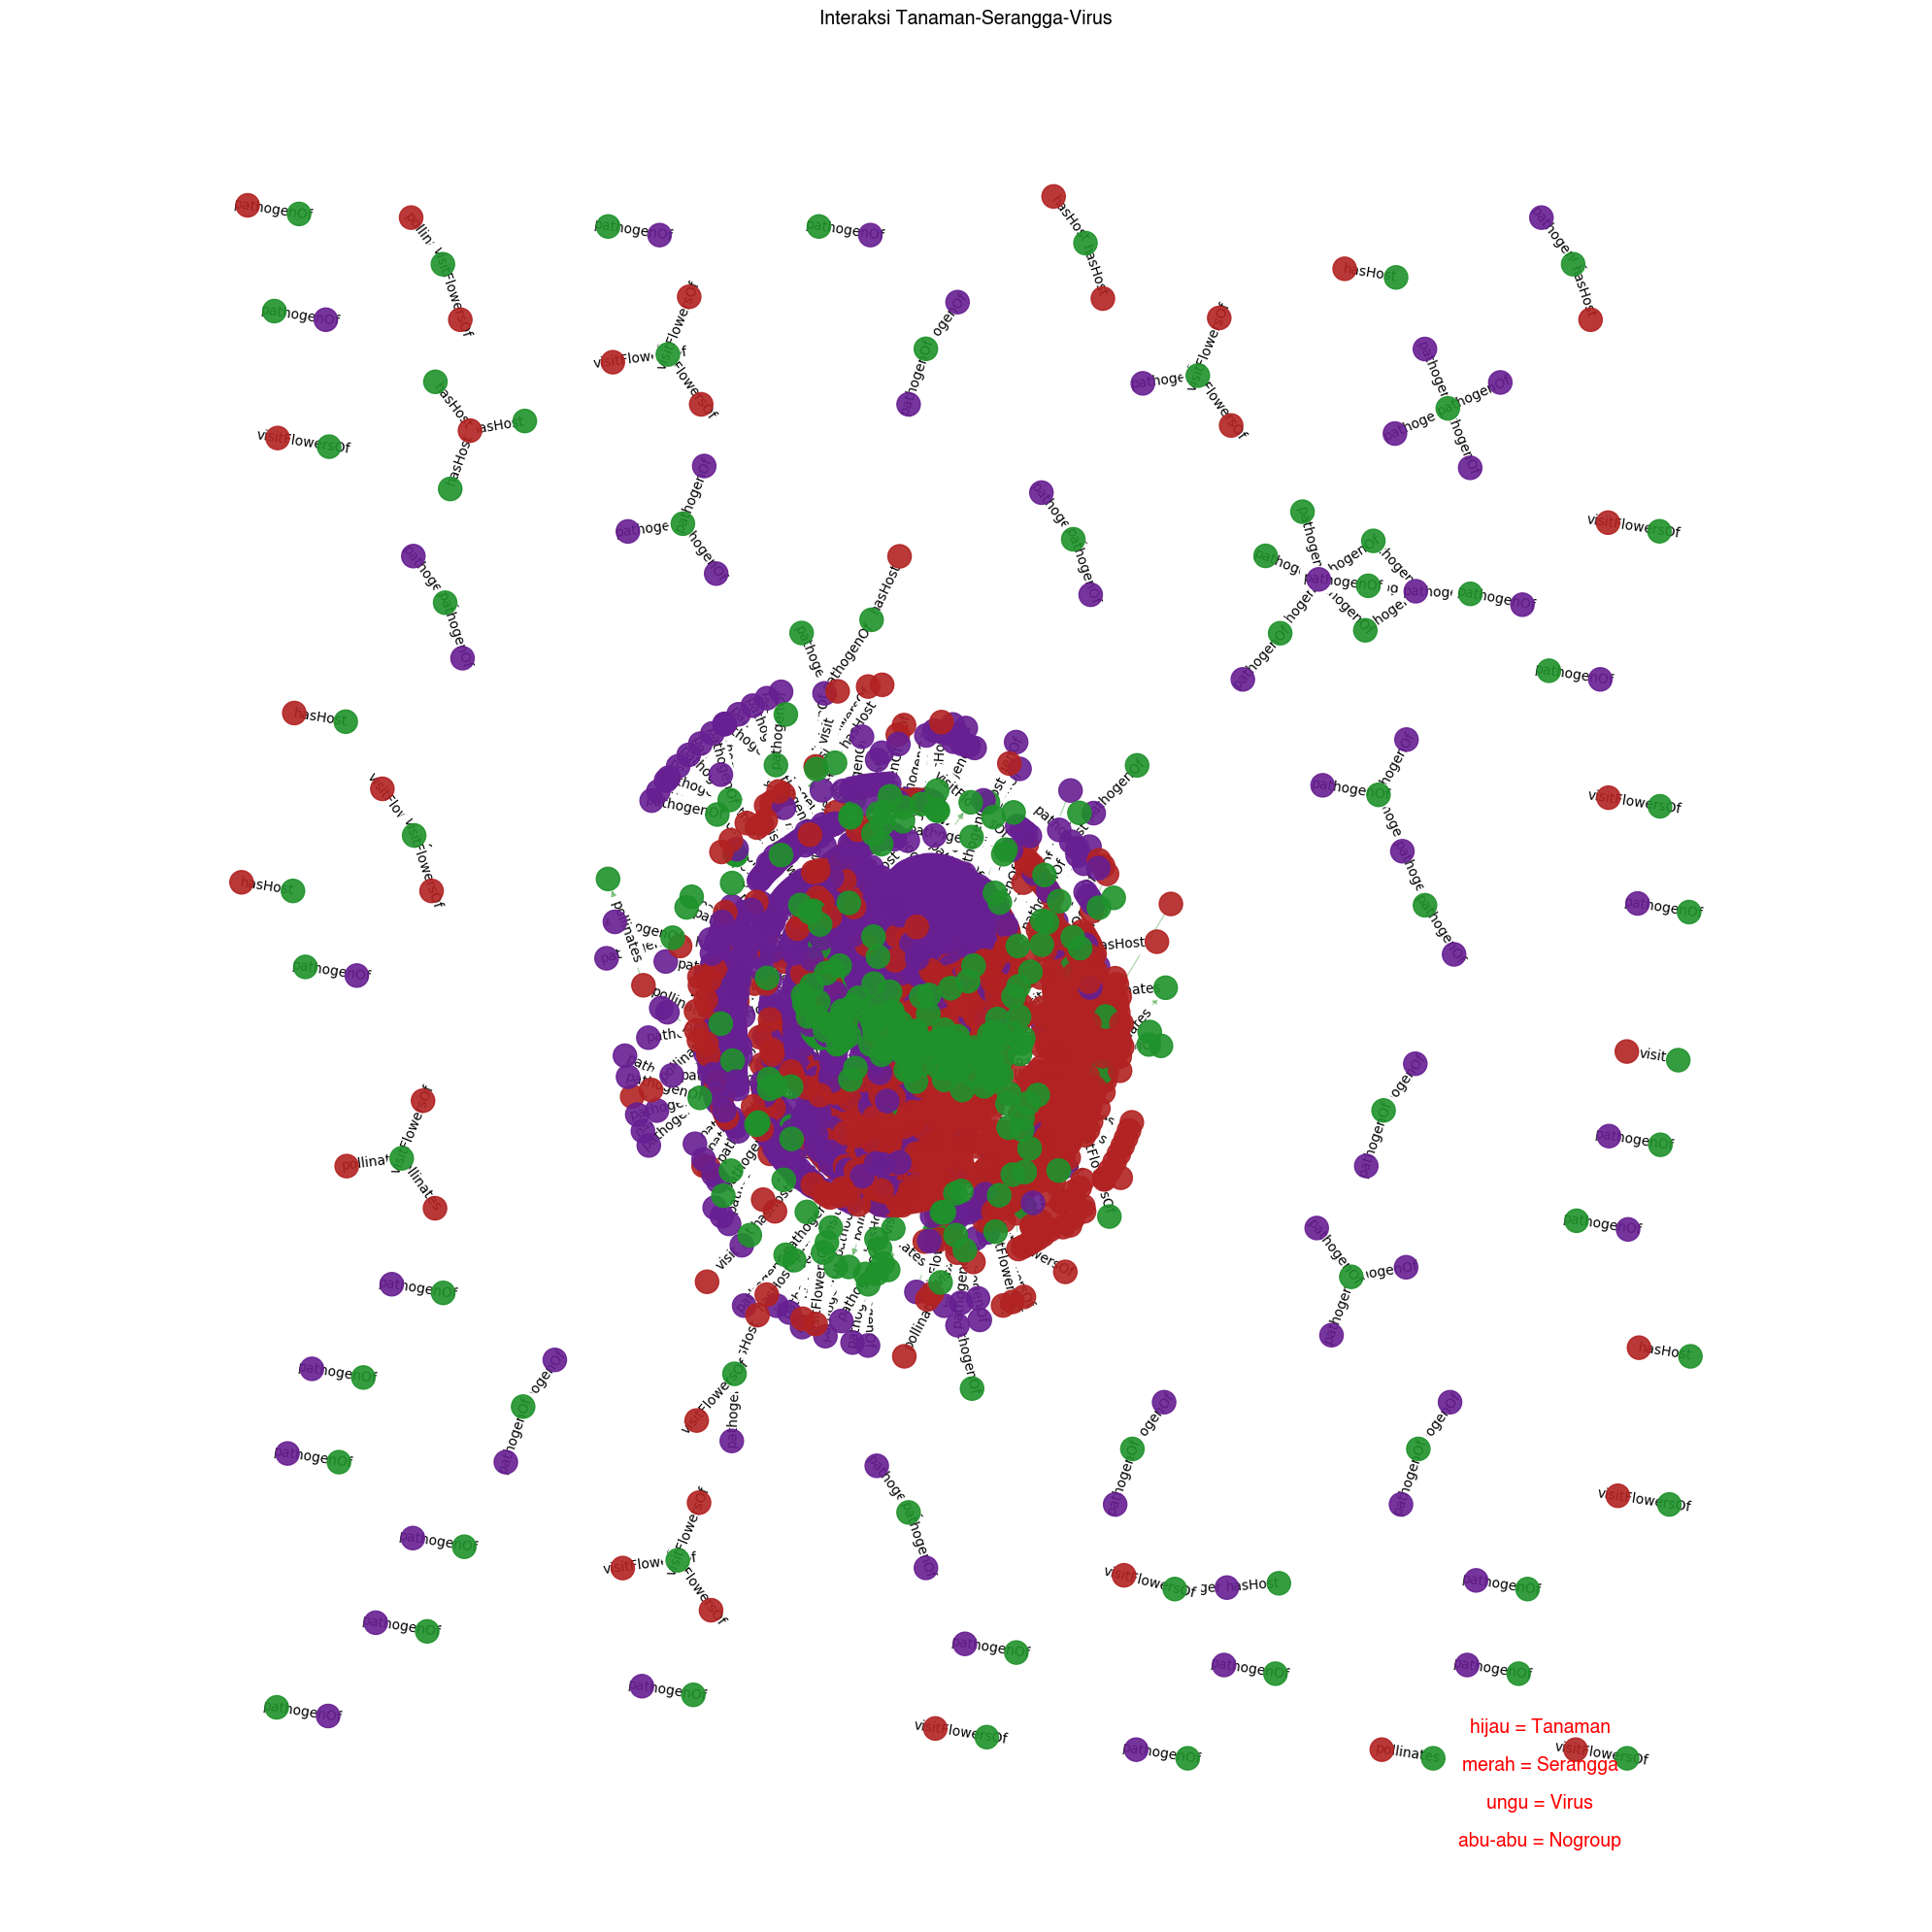

In [12]:
G=gnx

fig, ax = plt.subplots(figsize=(20, 20))

# Generate layout for visualization
# pos = nx.kamada_kawai_layout(G)
# pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G, prog="neato", args="")

# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='g')
nx.draw_networkx_nodes(G, pos, node_color=list(nx.get_node_attributes(G, "color").values()), alpha=0.9)

#node label
# for i in ['#b22222','#671f92','#1f922b','#EADDCA']: # filtering dengan bedakan warna node
#     label_options = {"ec": i, "fc": 'white', "alpha": 0.7}
#     nx.draw_networkx_labels(
#         nx.subgraph_view(G, filter_node=lambda n1: G.nodes(data=True)[n1].get("color", True) == i),
#         pos, 
#         font_size=10, 
#         bbox=label_options
#     )

#edge labels
edge_labels={x:i for i,x in zip(nx.get_edge_attributes(G, "label").values(),G.edges())}
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


# Title/legend
font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
ax.set_title("Interaksi Tanaman-Serangga-Virus", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "hijau = Tanaman",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.08,
    "merah = Serangga",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.06,
    "ungu = Virus",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.04,
    "abu-abu = Nogroup",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

# Detail entiti serangga dalam node

In [60]:
# from modul.helper_umum import contains_string_entire_column
# df_serangga_lebah = contains_string_entire_column(df_node[df_node['group']=='serangga'], 'Anthophila')
# df_serangga_lebah[df_serangga_lebah.order!='NCBI:7399_Hymenoptera']


# len(df_node),len(df_node[df_node['order']=='NCBI:7399_Hymenoptera'])
# df_serangga=df_node[df_node['group']=='serangga']

df_node_grouped=df_node.groupby(['group','order']).size().to_dict()
df_node_grouped
# dict(sorted(df_node_grouped.items(), key=lambda item: item[1],reverse=True))

{('serangga', 'NCBI:30262_Thysanoptera'): 21,
 ('serangga', 'NCBI:6993_Orthoptera'): 4,
 ('serangga', 'NCBI:7020_Phasmatodea'): 1,
 ('serangga', 'NCBI:7041_Coleoptera'): 100,
 ('serangga', 'NCBI:7088_Lepidoptera'): 204,
 ('serangga', 'NCBI:7147_Diptera'): 272,
 ('serangga', 'NCBI:7399_Hymenoptera'): 453,
 ('serangga', 'NCBI:7516_Neuroptera'): 1,
 ('serangga', 'NCBI:7524_Hemiptera'): 53,
 ('tanaman', 'NCBI:13798_Hypnales'): 1,
 ('tanaman', 'NCBI:16360_Alismatales'): 1,
 ('tanaman', 'NCBI:16736_Piperales'): 12,
 ('tanaman', 'NCBI:3524_Caryophyllales'): 13,
 ('tanaman', 'NCBI:35443_Trentepohliales'): 1,
 ('tanaman', 'NCBI:3646_Malpighiales'): 20,
 ('tanaman', 'NCBI:3699_Brassicales'): 21,
 ('tanaman', 'NCBI:3744_Rosales'): 5,
 ('tanaman', 'NCBI:4036_Apiales'): 2,
 ('tanaman', 'NCBI:40551_Arecales'): 1,
 ('tanaman', 'NCBI:4055_Gentianales'): 7,
 ('tanaman', 'NCBI:4069_Solanales'): 61,
 ('tanaman', 'NCBI:4143_Lamiales'): 40,
 ('tanaman', 'NCBI:41937_Sapindales'): 1,
 ('tanaman', 'NCBI:41938

In [48]:
sorted(nx.degree_centrality(gnx).items(), key=lambda item: item[1],reverse=True)

[('NCBI:4081', 0.12978244561140284),
 ('NCBI:4039', 0.09414853713428357),
 ('NCBI:4100', 0.05251312828207052),
 ('NCBI:4097', 0.045011252813203305),
 ('NCBI:3885', 0.04426106526631658),
 ('NCBI:3663', 0.040510127531882975),
 ('NCBI:3847', 0.038634658664666165),
 ('NCBI:7038', 0.03788447111777945),
 ('NCBI:4071', 0.034133533383345835),
 ('NCBI:4072', 0.03225806451612903),
 ('NCBI:443381', 0.030382595648912228),
 ('NCBI:4076', 0.028507126781695424),
 ('NCBI:3712', 0.0277569392348087),
 ('NCBI:568212', 0.027006751687921982),
 ('NCBI:68299', 0.02663165791447862),
 ('NCBI:3659', 0.02663165791447862),
 ('NCBI:50192', 0.02625656414103526),
 ('NCBI:2065972', 0.02625656414103526),
 ('NCBI:4120', 0.02513128282070518),
 ('NCBI:102777', 0.024756189047261817),
 ('NCBI:53866', 0.024381095273818456),
 ('NCBI:49606', 0.02288072018004501),
 ('NCBI:103756', 0.02288072018004501),
 ('NCBI:455045', 0.02138034508627157),
 ('NCBI:7460', 0.021005251312828207),
 ('NCBI:3726', 0.020255063765941488),
 ('NCBI:140